# Installs and Imports

In [ ]:
!pip install matplotlib
!pip install seaborn

In [1]:
# Fenics imports:
import dolfinx
import dolfinx.plot
import ufl

# Numerics imports:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np

# Visualisation imports:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Misc imports:
from math import sin, cos, pi, ceil, floor
import os
import json
import itertools
import time

In [ ]:
# Set plotting settings:
mpl.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

# FEM Code Functions

## Main Subroutine

In [ ]:
def solve_linear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps, el_order=2, rtol=1e-3, atol=1e-3, max_it=10):

    V = dolfinx.VectorFunctionSpace(mesh, ("CG", elem_order))

    bcs = create_bcs(mesh, V)
    
    # Compute Lame parameters:
    mu_val = E/(2*(1 + nu))
    mu = dolfinx.Constant(mesh, mu_val)
    lambda_ = dolfinx.Constant(mesh, kappa - (2/3)*mu_val)

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    def epsilon(u):
        return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
    def sigma(u):
        return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

    f = create_load_vector(g, rho, y_rot, x_rot, mesh)
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    L = ufl.dot(f, v) * ufl.dx
    
    # Delete cache of previous models:
    !rm -r /root/.cache/fenics/*
    
    problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u = problem.solve()
    
    volumes = compute_volume(u, mesh)
    
    return (u, mesh, volumes)

## Mesh + BCs

In [ ]:
def create_mesh(L, W, NL, NW):
    mesh = dolfinx.BoxMesh(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, W, W]], [NL, NW, NW], dolfinx.cpp.mesh.CellType.hexahedron)
    return mesh

In [ ]:
def create_bcs(mesh, V):
    fixed = lambda x: np.isclose(x[0], 0)
    fixed_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, fixed)
    facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, fixed_facets, 1)
    u_bc = dolfinx.Function(V)
    with u_bc.vector.localForm() as loc:
        loc.set(0)
    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
    bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]
    return bcs  

## Constitutive Equations

In [ ]:
def create_constitutive_eqn(E, nu, kappa, mesh, V, quad_degree=4):
    
    # Compute Lame parameters:
    mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
    
    # Compute new body force:
    B = dolfinx.Constant(mesh, (0,0,0))
    v = ufl.TestFunction(V)
    u = dolfinx.Function(V)
    d = len(u)
    I = ufl.variable(ufl.Identity(d))
    F = ufl.variable(I + ufl.grad(u))
    C = ufl.variable(F.T * F)
    J = ufl.variable(ufl.det(F))
    Ic = ufl.variable(ufl.tr(C))

    # Nearly-Incompressible Neo-Hookean material; 
    # See: https://link.springer.com/article/10.1007/s11071-015-2167-1
    psi = (mu/2)*(Ic-3) + kappa/2*(J-1)**2
    
    # Hyper-elasticity
    P = ufl.diff(psi, F)
    
    metadata = {"quadrature_degree": 4}
    dx = ufl.Measure("dx", metadata=metadata)

    # Define form F (we want to find u such that F(u) = 0)
    F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx
    
    return (F, u, B)

## Loading Functions

In [ ]:
def create_load_vector(y_rot, x_rot, rho, g, g_dir=(1,0,0)):
    f = rho*g*np.array(g_dir)
    f = rotate_vector(f, y_rot, x_rot)
    return f
    
# Using Euler angles - see https://www.autonomousrobotslab.com/frame-rotations-and-representations.html
# Here, y_rot = theta, x_rot = psi
def rotate_vector(f, y_rot, x_rot):
    rot_matrix = create_rot_matrix(y_rot, x_rot)
    rotated_f = rot_matrix @ f
    return rotated_f

def create_rot_matrix(y_rot, x_rot, ang_to_rad=pi/180):
    # NB: Negative associated with y so increasing y_rot goes in 'right direction'
    theta, psi = -ang_to_rad*y_rot, ang_to_rad*x_rot
    rot_matrix = np.array([[         cos(theta),        0,          -sin(theta)],
                           [sin(psi)*sin(theta),  cos(psi), sin(psi)*cos(theta)],
                           [cos(psi)*sin(theta), -sin(psi), cos(psi)*cos(theta)]])
    return rot_matrix

## Pre-Processing Functions

In [ ]:
def create_param_combos(**kwargs):
    keys = kwargs.keys()
    param_combos = []
    for bundle in itertools.product(*kwargs.values()):
        param_dict = dict(zip(keys, bundle))
        param_combos.append(param_dict)
    return param_combos

## Post-Processing Functions

In [ ]:
def compute_volumes(u, mesh, quad_order=4):
    
    before_vol, after_vol = [], []
    ndim = mesh.geometry.x.shape[1]
    I = ufl.Identity(ndim)
    dx = ufl.Measure("dx", domain=mesh, metadata={"quadrature_degree": quad_order})
    const_funspace = dolfinx.VectorFunctionSpace(mesh, ("DG", 0), dim=1)
    const_fun = dolfinx.Function(const_funspace)
    const_fun.vector[:] = np.ones(const_fun.vector[:].shape)
    ufl.inner(const_fun,const_fun)
    vol_before = dolfinx.fem.assemble.assemble_scalar(ufl.inner(const_fun,const_fun)*dx)
    F = I + ufl.grad(u)
    vol_after = dolfinx.fem.assemble.assemble_scalar(ufl.det(F)*dx)
    
    return [vol_before, vol_after]

In [ ]:
def get_end_displacement(u, mesh, W, L):
    u_vals = u.compute_point_values().real
    idx = np.isclose(mesh.geometry.x, [L, W, W])
    idx = np.where(np.all(idx, axis=1))
    u_vals = u_vals[idx]
    disp = np.sum(u_vals**2, axis=1)**(1/2)
    return disp.item()

# Parameter Fitting

In [ ]:
def convergence_study_kappa_and_meshsize(kappa_list, E_list, nu, elem_size, y_rot, x_rot, W, L, rho, g, num_steps):
    
    # Create mesh:
    NL, NW = ceil(L/elem_size), ceil(W/elem_size)
    mesh = create_mesh(L, W, NL, NW) 
    
    # Get all possible combinations of parameters:
    param_combos = create_param_combos(kappa=kappa_list, elem_size=elem_size_list)
    results = {key: [] for key in ('disp', 'volume', 'bulk_modulus', 'elem_size', 'num_elem')}
    
    for i, params in enumerate(param_combos):
        
        # Extract i'th set of parameters:
        kappa, elem_size = params['kappa'], params['elem_size']
        print(f"Simulating Mesh {i+1}/{len(param_combos)} (Kappa = {kappa}, Element Size = {elem_size})")
        
  
        
        # Compute number of elements in mesh:
        num_elem = NL * NW * NW
        
        # Compute displacement of beam:
        u, volumes = solve_nonlinear_problem(mesh, y_rot, x_rot, E, kappa, nu, rho, g, num_steps)
        
        # Compute displacement at very end of beam:
        end_disp = get_end_displacement(u, mesh, W, L)
        
        # Save results:
        results['disp'].append(end_disp)
        results['volume'].append(volumes)
        results['bulk_modulus'].append(kappa)
        results['elem_size'].append(elem_size)
        results['num_elem'].append(num_elem)
    
    # ALso save other simulation quantities:
    results['E'] = E
    results['nu'] = nu
    results['density'] = rho
    results['W'] = W
    results['L'] = L
    results['rot_y'] = rot_y
    results['rot_x'] = rot_x
    results['num_steps'] = num_steps
    
    return results

In [7]:
def parameter_fitting(num_elem_list, E_list, y_rot_list, fixed_params):
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Initialise list to store results:
    results_dict = {'End Displacement':[], 'Number of Elements':[], 'Element Size':[]}
    
    # Iterate over all mesh elements to explore 
    for i, num_elem in enumerate(num_elem_list):
        print(f'Simulating Mesh {i+1}/{len(num_elem_list)} (Number of elements = {num_elem})')
        
        # Compute size of elements:
        elem_size = (beam_vol/num_elem)**(1/3)
        results_dict['Element Size'].append(elem_size)
        
        # First, create 'fixed' parameters of model:
        fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
        results_dict['Number of Elements'].append(true_num_elem)
        
        # Performing loading:
        u_vals = perform_loading(E, beam_angle, fixed_params, fem_objects)
        
        # Get displacement at end of beam:
        idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
        idx_2_get = np.where(np.all(idx_2_get, axis=1))
        disp_vals = np.sum(u_vals**2, axis=1)**(1/2)
        results_dict['End Displacement'].append(disp_vals[idx_2_get].item())
        print(f'End disp = {disp_vals[idx_2_get]}')
    
    # Also store fixed parameters with results:
    results_dict['E'] = E
    results_dict['Beam Angle'] = beam_angle
    results_dict.update(fixed_params)
    
    return results_dict

In [8]:
# Material constants:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2

# Beam dimensions:
W = 40 # in mm
L = 90 # in mm

# FEM parameters:
el_order = 2

# Store parameters in dictionary:
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W}

# Define stiffness and beam angle to perform convergence study for:
E = 10
beam_angle = 90

# Define number of elements to check:
num_elem_list = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    
# Create results dictionary:
convergence_results = mesh_convergence(num_elem_list, E, beam_angle, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_convergence.json"
with open('./'+save_name, 'w') as f:
    json.dump(convergence_results, f, indent=4)

Simulating Mesh 1/11 (Number of elements = 100)
c_5
End disp = [72.89]
Simulating Mesh 2/11 (Number of elements = 250)
c_7


KeyboardInterrupt: 

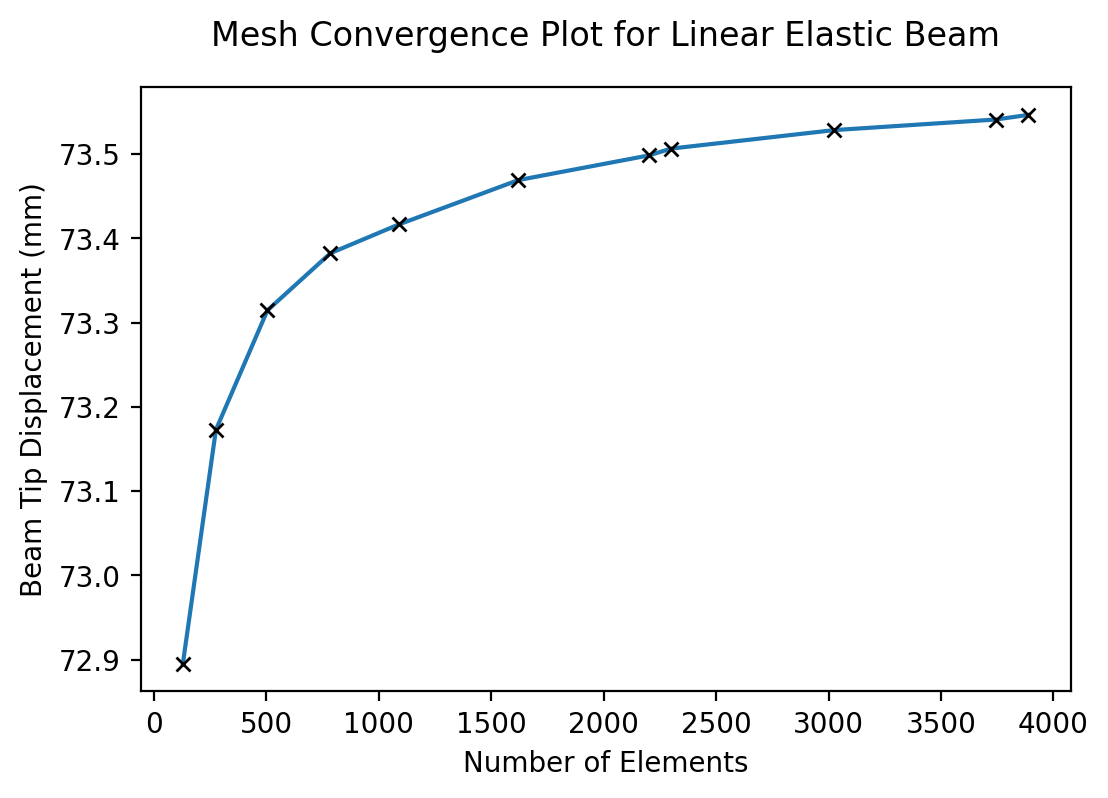

In [17]:
# Mesh convergence plot:
import json
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 200

with open('./linear_convergence.json', 'r') as f:
    convergence_results = json.load(f)
fig, ax = plt.subplots()
plt.plot(convergence_results['Number of Elements'], convergence_results['End Displacement'])
plt.title('Mesh Convergence Plot for Linear Elastic Beam', pad=15)
ax.set_xlabel('Number of Elements')
ax.set_ylabel('Beam Tip Displacement (mm)')
fig.patch.set_facecolor('white')
plt.plot(convergence_results['Number of Elements'], convergence_results['End Displacement'], 'x', color='black', markersize=5)
plt.show()

From above plot, looks like 3000 elements should be more than enough.

# Generate Data

In [4]:
def create_param_combos(param_list):
    keys = param_list.keys()
    param_combos = []
    for bundle in itertools.product(*param_list.values()):
        param_dict = dict(zip(keys, bundle))
        param_combos.append(param_dict)
    return param_combos

In [5]:
def create_data(params_dict, num_elem, fixed_params): 
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Compute size of elements:
    elem_size = (beam_vol/num_elem)**(1/3)
    
    # Generate FEM objects - these won't change between simulations:
    fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
    
    # Compute index of node to get displacement from:
    idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
    idx_2_get = np.where(np.all(idx_2_get, axis=1))
    
    # Generate all possible combinations of training data parameters:
    param_combos = create_param_combos(params_dict)
    results_dict = {'E':[], 'Beam Angle':[], 'End Displacement':[]}
    
    for i, params in enumerate(param_combos):
        print(f"Computing data point {i+1}/{len(param_combos)}")
        results_dict['E'].append(params['E'])            
        results_dict['Beam Angle'].append(params['angle']) 
        u_val = perform_loading(params['E'], params['angle'], fixed_params, fem_objects)
        disp = np.sum(u_val**2, axis=1)**(1/2)               
        results_dict['End Displacement'].append(disp[idx_2_get].item())
                                
    # Store fixed parameters and element size in this dictionary as well:
    results_dict["Element size"] = elem_size
    results_dict["Number of Elements"] = true_num_elem
    results_dict.update(fixed_params)
    
    return results_dict

In [6]:
# Define set of fixed parameters:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
W = 40 # in mm
L = 90 # in mm
el_order = 2
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W}

# Define number of elements:
num_elem = 2500

In [7]:
# First create training data:
num_pts = 10
min_E, max_E = 10, 40
min_ang, max_ang = 0, 180
train_params = {'E': np.linspace(min_E, max_E, num_pts),
                'angle': np.linspace(min_ang, max_ang, num_pts)}

training_dict = create_data(train_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_train.json"
with open('./'+save_name, 'w') as f:
    json.dump(training_dict, f, indent=4)

Computing data point 1/100
Computing data point 2/100
Computing data point 3/100
Computing data point 4/100
Computing data point 5/100
Computing data point 6/100
Computing data point 7/100
Computing data point 8/100
Computing data point 9/100
Computing data point 10/100
Computing data point 11/100
Computing data point 12/100
Computing data point 13/100
Computing data point 14/100
Computing data point 15/100
Computing data point 16/100
Computing data point 17/100
Computing data point 18/100
Computing data point 19/100
Computing data point 20/100
Computing data point 21/100
Computing data point 22/100
Computing data point 23/100
Computing data point 24/100
Computing data point 25/100
Computing data point 26/100
Computing data point 27/100
Computing data point 28/100
Computing data point 29/100
Computing data point 30/100
Computing data point 31/100
Computing data point 32/100
Computing data point 33/100
Computing data point 34/100
Computing data point 35/100
Computing data point 36/100
C

In [8]:
# Next create test data:
delta_E = (max_E-min_E)/(num_pts-1)
delta_ang = (max_ang-min_ang)/(num_pts-1)
E_test = [E for E in np.linspace(min_E+0.5*delta_E, max_E-0.5*delta_E, num_pts-1)]
angle_test = [angle for angle in np.linspace(min_ang+0.5*delta_ang, max_ang-0.5*delta_ang, num_pts-1)]
test_params = {"E": E_test, "angle": angle_test}

test_dict = create_data(test_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_test.json"
with open('./'+save_name, 'w') as f:
    json.dump(test_dict, f, indent=4)

Computing data point 1/81
Computing data point 2/81
Computing data point 3/81
Computing data point 4/81
Computing data point 5/81
Computing data point 6/81
Computing data point 7/81
Computing data point 8/81
Computing data point 9/81
Computing data point 10/81
Computing data point 11/81
Computing data point 12/81
Computing data point 13/81
Computing data point 14/81


IOStream.flush timed out


Computing data point 15/81
Computing data point 16/81


IOStream.flush timed out


Computing data point 17/81
Computing data point 18/81
Computing data point 19/81
Computing data point 20/81
Computing data point 21/81
Computing data point 22/81
Computing data point 23/81
Computing data point 24/81
Computing data point 25/81
Computing data point 26/81
Computing data point 27/81
Computing data point 28/81
Computing data point 29/81
Computing data point 30/81
Computing data point 31/81
Computing data point 32/81
Computing data point 33/81
Computing data point 34/81
Computing data point 35/81
Computing data point 36/81
Computing data point 37/81
Computing data point 38/81
Computing data point 39/81
Computing data point 40/81
Computing data point 41/81
Computing data point 42/81
Computing data point 43/81
Computing data point 44/81
Computing data point 45/81
Computing data point 46/81
Computing data point 47/81
Computing data point 48/81
Computing data point 49/81
Computing data point 50/81
Computing data point 51/81
Computing data point 52/81
Computing data point 53/81
C

# Plot Data

In [24]:
# Let's plot the training and test data:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

mpl.rcParams['figure.dpi'] = 200

def plot_data(data, grid_shape, num_levels, E_lims=None, angle_lims=None, y_lims=None, title=None):

    angle, E, y = np.array(data['Beam Angle']), np.array(data['E']), np.array(data['End Displacement'])
    
    levels = np.linspace(y_lims[0], y_lims[1], num_levels)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(E.reshape(grid_shape), angle.reshape(grid_shape), y.reshape(grid_shape), 
                              levels=levels, cmap=cm.coolwarm)
    
    ticks = np.array(range(y_lims[0], y_lims[1]+1, 20))
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label('Beam Tip Displacement (mm)', rotation=270, labelpad=15)
    ax.set_xlabel("Young's Modulus (kPa)")
    ax.set_ylabel('Beam Angle (degrees)')
    ax.set_xlim(E_lims)
    ax.set_ylim(angle_lims)
    plt.title(title, pad=15)
    plt.plot(E, angle, 'x', color='black', markersize=3)
    fig.patch.set_facecolor('white')
    plt.show()

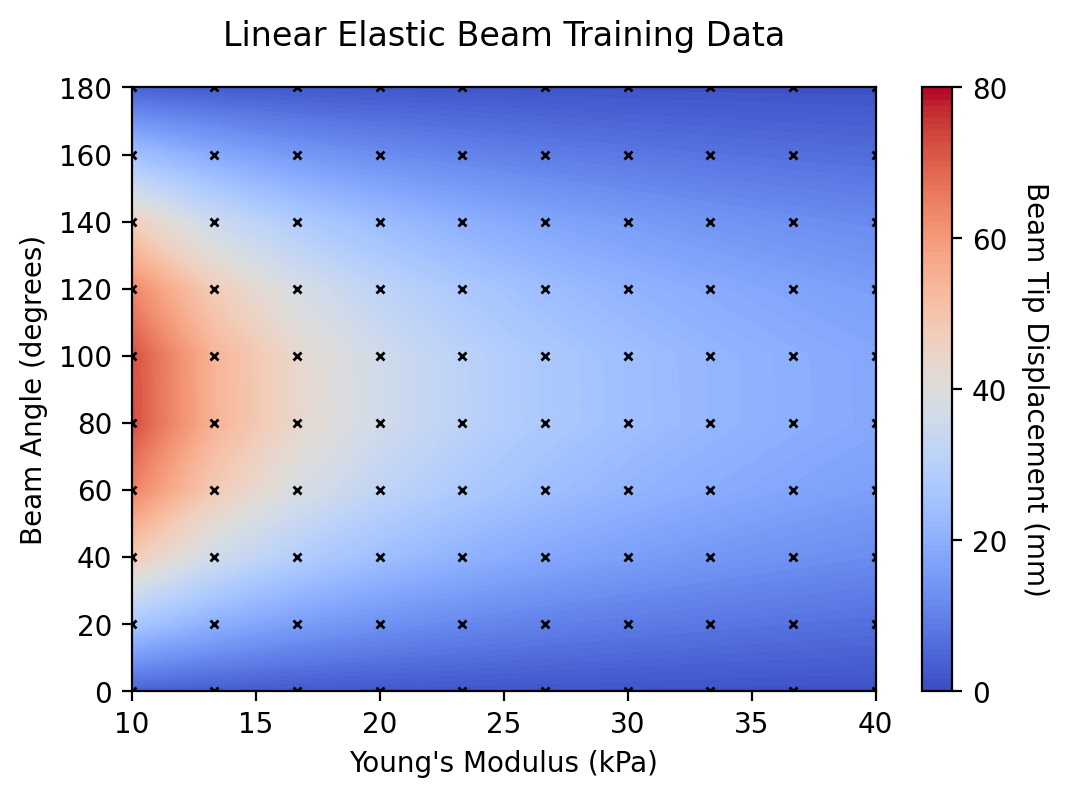

In [25]:
with open('linear_train.json', 'r') as f:
    training_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (10, 10)
num_levels = 100
title = "Linear Elastic Beam Training Data"
plot_data(training_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims, title)

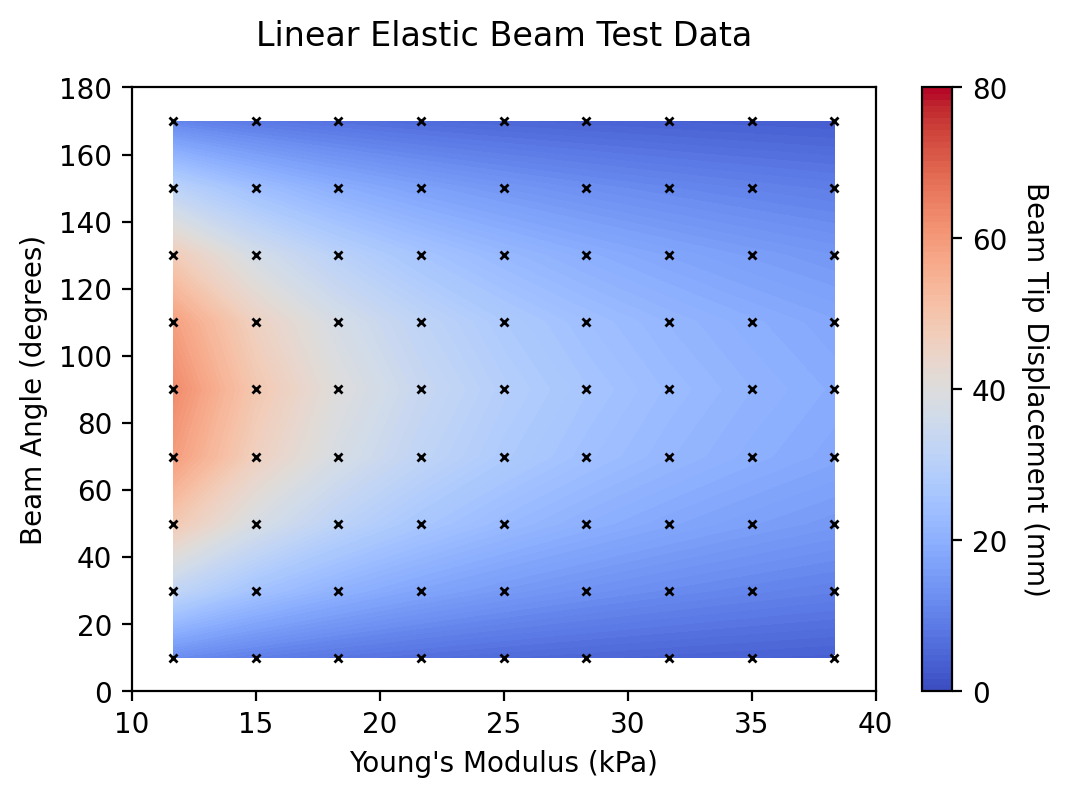

In [26]:
with open('linear_test.json', 'r') as f:
    test_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (9, 9)
num_levels = 100
title = "Linear Elastic Beam Test Data"
plot_data(test_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims, title)